In [1]:
import os
import torch
from skimage import transform, io

import pandas
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [5]:
class DatasetLoader(Dataset):
    def __init__(self, path_to_dataset: str, amount_of_photo_at_dir:int, im_w: int, im_h: int, channels=3):
        self.path_to_dataset = path_to_dataset + '/'
        self.data = []
        self.amount_of_photo = amount_of_photo_at_dir
        self.image_width = im_w 
        self.image_height = im_h
        self.image_channels = channels
        
    def load(self, train_size: float = 0.7) -> tuple[torch.Tensor, torch.Tensor] | torch.Tensor:
        # TODO: може попасти таке шо не може бути sorted
        count_of_dirs = len(os.listdir(self.path_to_dataset)) 
       
        train_size = round(count_of_dirs * train_size)
        
        for dirname in sorted(os.listdir(self.path_to_dataset)):
            for filename in sorted(os.listdir(self.path_to_dataset + dirname)):
                image = io.imread(os.path.join(self.path_to_dataset + dirname, filename))
                image = image.reshape(self.image_channels, self.image_height, self.image_width)
                    
                self.data.append(image)
                
        try:
            dataset = torch.tensor(self.data).view(count_of_dirs,
                                                   self.amount_of_photo,
                                                   self.image_channels,
                                                   self.image_height,
                                                   self.image_width)
            dataset = dataset / 255
            train_dataset = dataset[:train_size]
            test_dataset = dataset[train_size:]
            return train_dataset, test_dataset
        
        except Exception as e:
            print(e)
            print("Your given form is not correct, check your data")
            return torch.tensor([])
        
swipe_dataset_train, swipe_dataset_test = DatasetLoader('C:/Users/redpy/OneDrive/Рабочий стол/pythonProject/SwipeDetector/datasets/canny_filter_swipe-up',
                              amount_of_photo_at_dir=5,
                              im_w=100,
                              im_h=200, channels=1).load(train_size=0.8)

swipe_dataset_train.shape, swipe_dataset_train.dtype

(torch.Size([56, 5, 1, 200, 100]), torch.float32)

In [7]:
default_pose_dataset_train, default_pose_dataset_test = DatasetLoader(
    'C:/Users/redpy/OneDrive/Рабочий стол/pythonProject/SwipeDetector/datasets/canny_filter_default',
    amount_of_photo_at_dir=5,
    im_w=100,
    im_h=200,
    channels=1
).load(train_size=0.8)

default_pose_dataset_train.shape, default_pose_dataset_train.dtype

(torch.Size([56, 5, 1, 200, 100]), torch.float32)

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [42]:
class ConvLSTM(nn.Module):
    def __init__(self, num_classes_to_predict):
        super().__init__()
        
        self.tanh = nn.Tanh() 
        self.relu = nn.ReLU()
        
        self.conv1 = nn.Conv3d(in_channels=1, out_channels=32, kernel_size=(1, 10, 10)) 
         
        self.maxpool = nn.MaxPool3d(kernel_size=(1, 5, 5))
        
        self.conv2 = nn.Conv3d(in_channels=32, out_channels=16, kernel_size=(1, 5, 5))
        
        self.fc = nn.Linear(960, 2000)
        
        self.lstm = nn.LSTM(2000, 1000, batch_first=True) 
        
        self.fc1 = nn.Linear(1000, num_classes_to_predict)
        
        self.softmax = nn.Softmax(dim=1)

        nn.init.kaiming_normal_(self.fc1.weight)
        
        nn.init.kaiming_uniform_(self.conv1.weight)
        nn.init.kaiming_uniform_(self.conv2.weight)
        
    def forward(self, x):
        B = x.shape[0]
        
        x = self.maxpool(self.relu(self.conv1(x)))
        x = nn.functional.dropout(x, p=0.3, training=self.training)
        x = self.maxpool(self.relu(self.conv2(x)))
        x = nn.functional.dropout(x, p=0.3, training=self.training)
        x = x.view(B, -1)
        
        x = self.tanh(self.fc(x))
        
        h_t, c_t = self.lstm(x)
        h_t = nn.functional.dropout(h_t, p=0.3, training=self.training)
        x = self.tanh(self.fc1(h_t))
        
        return self.softmax(x), h_t, c_t 
        

model = ConvLSTM(num_classes_to_predict=2).to(device)

print(sum(p.numel() for p in model.parameters()))

13948050


In [43]:
n = 2
classes = torch.eye(n=n) 
print(classes, '<- classes')

# 0 -> Default
# 1 -> Swipe-up
default_pose_dataset_targets = torch.expand_copy(classes[0],
                                                 size=(default_pose_dataset_train.shape[0], default_pose_dataset_train.shape[1],n))

swipe_up_targets = torch.expand_copy(classes[1],
                                     size=(swipe_dataset_train.shape[0], swipe_dataset_train.shape[1], n))


X_train = torch.concat(tensors=(swipe_dataset_train, default_pose_dataset_train), dim=0).to(device)

Y_train =  torch.concat(tensors=(swipe_up_targets, default_pose_dataset_targets), dim=0).to(device)

tensor([[1., 0.],
        [0., 1.]]) <- classes


In [44]:
lr = 0.000001 # lr = 0.00001 <- were good lr
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
epochs = 300 
lossi = []

In [45]:
model.train()

for epoch in range(epochs):
    for i, v in enumerate(X_train):
        inp = X_train[i].view(1, 1, 5, 200, 100)
        target = Y_train[i]
        
        pred, _, _ = model(inp)
        
        loss = criterion(pred, target[0].unsqueeze(0))
        
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        lossi.append(loss.item()) 
        optimizer.step()
    if epoch % 10 == 0:
        print(epoch, f"Loss = {loss.item()}")
print(loss.item()) 

0 Loss = 0.7293956279754639
10 Loss = 0.6932823657989502
20 Loss = 0.6456011533737183
30 Loss = 0.5621050596237183
40 Loss = 0.6041978597640991
50 Loss = 0.5013479590415955
60 Loss = 0.4990772306919098
70 Loss = 0.46013057231903076
80 Loss = 0.4815797805786133
90 Loss = 0.5487167239189148
100 Loss = 0.5512876510620117
110 Loss = 0.4525159001350403
120 Loss = 0.4529133439064026
130 Loss = 0.48744937777519226
140 Loss = 0.49019426107406616
150 Loss = 0.5009514093399048
160 Loss = 0.44725510478019714
170 Loss = 0.5501126646995544
180 Loss = 0.4145814776420593
190 Loss = 0.47127771377563477
200 Loss = 0.4391799867153168
210 Loss = 0.4096238613128662
220 Loss = 0.503911554813385
230 Loss = 0.4104084074497223
240 Loss = 0.5498855113983154
250 Loss = 0.4148957431316376
260 Loss = 0.43826860189437866
270 Loss = 0.40663427114486694
280 Loss = 0.5287656784057617
290 Loss = 0.4800475835800171
0.41628319025039673


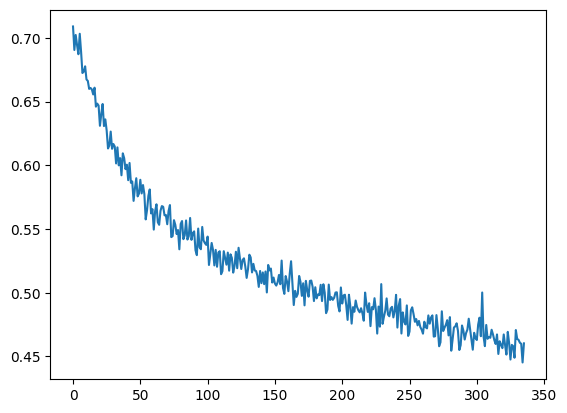

In [46]:
plt.plot(torch.tensor(lossi).view(-1, 100).mean(dim=1))

In [49]:
model.eval()
total = 0
correct = 0

default_pose_dataset_targets_test = torch.expand_copy(classes[0],
                                                 size=(default_pose_dataset_test.shape[0], default_pose_dataset_test.shape[1],n))

swipe_up_targets_test = torch.expand_copy(classes[1],
                                     size=(swipe_dataset_test.shape[0], swipe_dataset_test.shape[1], n))


X_test = torch.concat((swipe_dataset_test, default_pose_dataset_test), dim=0).to(device)
Y_test = torch.concat((swipe_up_targets_test, default_pose_dataset_targets_test), dim=0).to(device)


for i, v in enumerate(X_test):
    inp = X_test[i].view(1, 1, 5, 200, 100)
    tg = Y_test[i].to(torch.int64)
    pred, _, _ = model(inp)
    if classes.to(torch.int64).to(device)[pred.argmax(dim=1)].allclose(tg[0]):
        correct += 1
    total += 1

print(f"{correct / total * 100:.3}")

75.0


In [50]:
torch.save(model.state_dict(), 'canny_v4_drop')